In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "field",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 7719 files belonging to 184 classes.


In [4]:
class_name = dataset.class_names
class_name

['abies_concolor',
 'abies_nordmanniana',
 'acer_campestre',
 'acer_ginnala',
 'acer_griseum',
 'acer_negundo',
 'acer_palmatum',
 'acer_pensylvanicum',
 'acer_platanoides',
 'acer_pseudoplatanus',
 'acer_rubrum',
 'acer_saccharinum',
 'acer_saccharum',
 'aesculus_flava',
 'aesculus_glabra',
 'aesculus_hippocastamon',
 'aesculus_pavi',
 'ailanthus_altissima',
 'albizia_julibrissin',
 'amelanchier_arborea',
 'amelanchier_canadensis',
 'amelanchier_laevis',
 'asimina_triloba',
 'betula_alleghaniensis',
 'betula_jacqemontii',
 'betula_lenta',
 'betula_nigra',
 'betula_populifolia',
 'broussonettia_papyrifera',
 'carpinus_betulus',
 'carpinus_caroliniana',
 'carya_cordiformis',
 'carya_glabra',
 'carya_ovata',
 'carya_tomentosa',
 'castanea_dentata',
 'catalpa_bignonioides',
 'catalpa_speciosa',
 'cedrus_atlantica',
 'cedrus_deodara',
 'cedrus_libani',
 'celtis_occidentalis',
 'celtis_tenuifolia',
 'cercidiphyllum_japonicum',
 'cercis_canadensis',
 'chamaecyparis_pisifera',
 'chamaecyparis

In [5]:
len(dataset)

242

In [6]:
242*32

7744

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[140 158 122   6 167  59  66 165  94   5 168   6 161 167 120  23 138  46
  75 151 169  75  12 149 164 100 177 139 134  63  66 102]


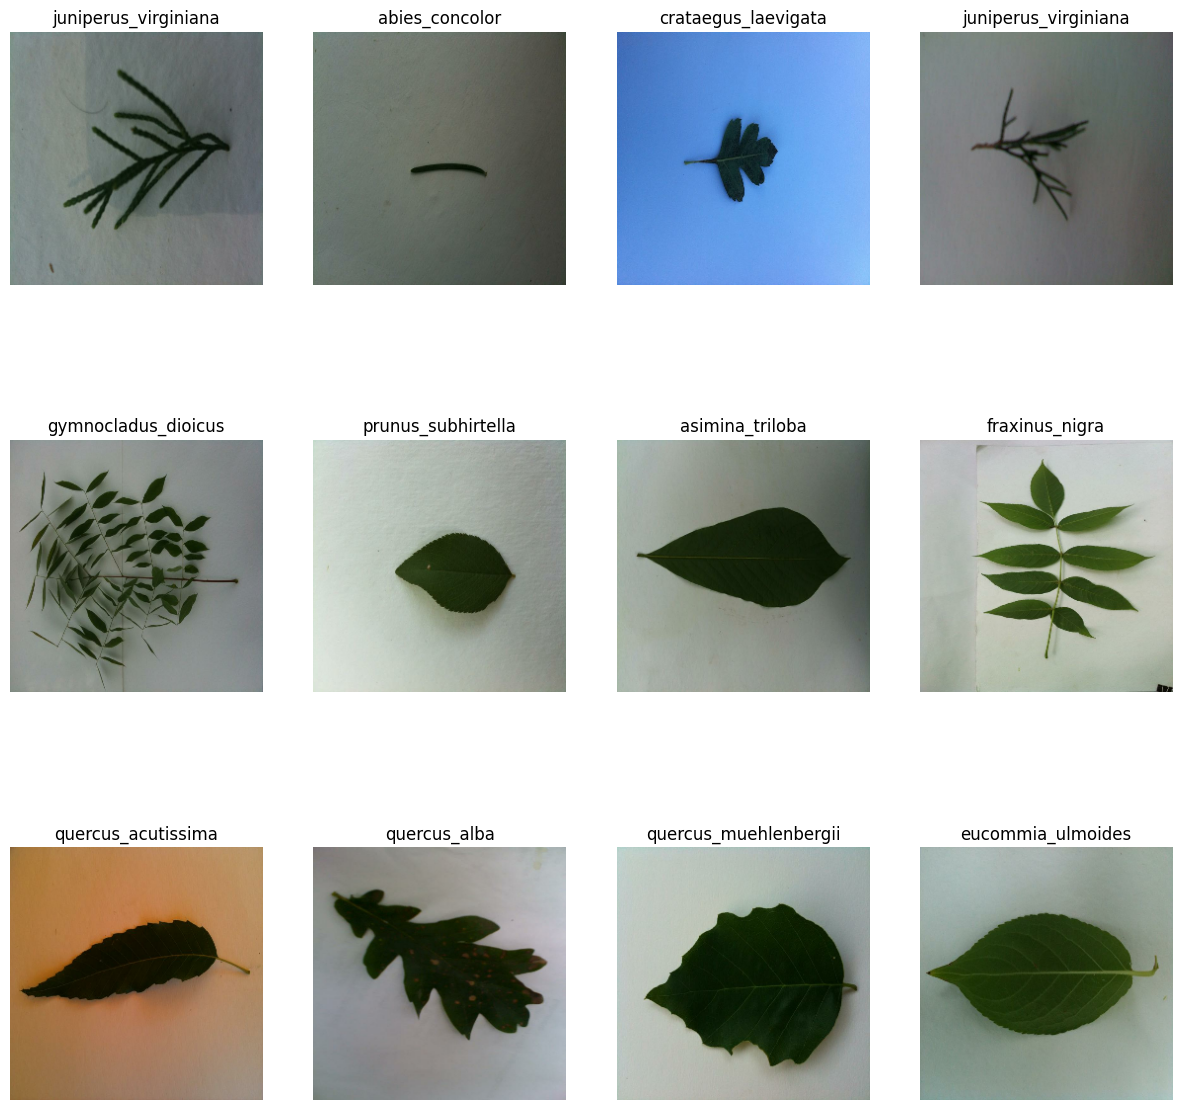

In [8]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[label_batch[i]])
        plt.axis("off")

In [9]:
train_size = 0.8
len(dataset)*train_size

193.60000000000002

In [ ]:
train_ds = dataset.take(193)
len(train_ds)

In [ ]:
test_ds = dataset.skip(193)
len(test_ds)

In [ ]:
val_size = 0.1
len(dataset)*val_size

In [ ]:
val_ds = test_ds.take(24)
len(val_ds)

In [ ]:
test_ds = test_ds.skip(24)
len(test_ds)

In [10]:
def get_dataset_partition(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partition(dataset)

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [13]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [14]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [15]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 184

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])


In [16]:
model.build(input_shape = input_shape)

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [18]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [19]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
193/193 [==============================] - 305s 2s/step - loss: 4.9853 - accuracy: 0.0330 - val_loss: 4.3821 - val_accuracy: 0.0391
Epoch 2/50
193/193 [==============================] - 254s 1s/step - loss: 3.7995 - accuracy: 0.1247 - val_loss: 3.1423 - val_accuracy: 0.1927
Epoch 3/50
193/193 [==============================] - 249s 1s/step - loss: 3.0039 - accuracy: 0.2422 - val_loss: 2.6282 - val_accuracy: 0.2878
Epoch 4/50
193/193 [==============================] - 252s 1s/step - loss: 2.5625 - accuracy: 0.3237 - val_loss: 2.4393 - val_accuracy: 0.3451
Epoch 5/50
193/193 [==============================] - 242s 1s/step - loss: 2.2044 - accuracy: 0.3985 - val_loss: 2.0726 - val_accuracy: 0.4036
Epoch 6/50
193/193 [==============================] - 281s 1s/step - loss: 1.9290 - accuracy: 0.4613 - val_loss: 1.7437 - val_accuracy: 0.4883
Epoch 7/50
193/193 [==============================] - 328s 2s/step - loss: 1.6719 - accuracy: 0.5217 - val_loss: 1.6199 - val_accuracy: 0.5247

In [26]:
model.save("plant.h5")

In [24]:
import os
model_version=max([int(i) for i in os.listdir("./models") + [0]])+1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/1\assets


INFO:tensorflow:Assets written to: ./models/1\assets
